In [1]:
from matplotlib import pyplot as plt
import numpy as np
import dill
import matplotlib as mpl
plt.style.use("/home/kjeong/.config/matplotlib/custom.mplstyle")

k_ls = [100, 200, 400, 600]+[1000, 1500, 2000, 3000]
rn_ls = [0, 1, 2]
lag_ls = [100, 200, 400, 600, 800, 900] 
#mem_ls = [0, 1, 4, 9]
div_ls = [1, 4, 2, -4]

workdir = "/project/dinner/kjeong/insulin/pipeline/step7_5ns"
ntraj = 28*28*24
length = 1000

In [2]:
plt.style.use("/home/kjeong/.config/matplotlib/custom.mplstyle")
plt.rcParams["text.latex.preamble"] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{cmbright}'#\usepackage{sansmath}\sansmath
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.sans-serif"] = 'cmbright'

In [3]:
inv_rate_arr = np.load(f"{workdir}/step4_rate/div/inv_rate_arr.npy")
inv_rate_arr_hk = np.load(f"{workdir}/step4_rate/div/inv_rate_arr_hk.npy")
inv_rate_arr = np.vstack((inv_rate_arr, inv_rate_arr_hk))
print(f"k_ls, rn_ls, lag_ls, div_ls: {inv_rate_arr.shape}")

k_ls, rn_ls, lag_ls, div_ls: (8, 3, 6, 4)


In [4]:
inv_rate_mem = np.load(f"{workdir}/step4_rate/mem/inv_rate_arr.npy")
inv_rate_mem_hk = np.load(f"{workdir}/step4_rate/mem/inv_rate_arr_hk.npy")
inv_rate_mem = np.vstack((inv_rate_mem[:, 0, :, :2], inv_rate_mem_hk[:, 0]))
print(f"k_ls, lag_ls, mem_ls: {inv_rate_mem.shape}")
inv_rate_mem[-4:, 3:, 1] = np.nan 

k_ls, lag_ls, mem_ls: (8, 6, 2)


In [5]:
#Information needed to convert R_AB to k_AB: w_us and qf_unq_mem
# Load US weight
P_beagle=f"/beagle3/dinner/kjeong"
us_path=f"{P_beagle}/insulin_backedup/NVT_US_ins/cvs"
psis=np.load(f'{us_path}/input_PMFdata/t_50/Psis50.npy')
z=np.load(f'{us_path}/input_PMFdata/t_50/Zs50.npy')

nwindow, nframe_us = psis.shape[:-1]
nwindow_ax = int(np.sqrt(nwindow))
ntraj_w=24
ntraj = nwindow*ntraj_w
weight_us_all = np.zeros((nwindow, nframe_us))# (window, nframe per each traj 1050 )
for i0 in range(nwindow):
    psi_sum = np.sum(psis[i0], axis=1)
    weight_us_all[i0] = z[i0]/(psi_sum*nframe_us)
#/project/dinner/kjeong/insulin/pipeline/step0_catdcd
weight_us = weight_us_all[:, 42:1050:42]

w_us = np.repeat(np.ravel(weight_us), length).reshape(ntraj, length)

state_arr = np.load(f"{workdir}/step1_cvs_state/state_arr.npy")
state_arr_hk = np.load(f"{workdir}/step1_cvs_state/state_arr_hk.npy")
state_arr = np.vstack((state_arr, state_arr_hk))[:, 0]
print(state_arr.shape)

with open(f"{workdir}/step3_lag_mem/output/qf_unq_mem.pkl", "rb") as f:
    qf_unq_mem = dill.load(f)
with open(f"{workdir}/step3_lag_mem/output/qf_unq_mem_hk.pkl", "rb") as f:
    qf_unq_mem_hk = dill.load(f)
qf_unq_mem = qf_unq_mem + qf_unq_mem_hk

print(len(qf_unq_mem), qf_unq_mem[4].shape)
print(len(qf_unq_mem_hk), qf_unq_mem_hk[0].shape)

(8, 18816000)
8 (3, 6, 3, 1000)
4 (3, 6, 3, 1000)


In [6]:
lag_choice = [0, 1, 2, 3, 4]
k_choice = [1, 3, 6]

In [7]:
print(np.array(k_ls)[k_choice])
print(np.array(lag_ls)[lag_choice])

[ 200  600 2000]
[100 200 400 600 800]


In [8]:
invk_AB = np.zeros((len(k_choice), len(lag_choice), 2))
for i_k, k_id in enumerate(k_choice):
    st_uq, st_id, st_inv = np.unique(state_arr[k_id], return_index=True, return_inverse=True)
    for i_lag, lag_tmp in enumerate(np.array(lag_ls)[lag_choice]):
        w_us_tmp = np.copy(w_us)
        w_us_tmp[:, -lag_tmp:]=0
        w_us_tmp = w_us_tmp/np.sum(w_us_tmp)
        
        for i_mem in [0,1]:
            q_tmp = qf_unq_mem[k_id][0, i_lag, i_mem]
            q_arr = np.zeros(ntraj*length)
            for i_st, q_val in enumerate(q_tmp):
                q_arr[st_inv==i_st] = q_val
            
            time_in_A = np.sum(np.ravel(w_us_tmp)*(1-q_arr))
            print(f"k_id:{k_id}, lag:{lag_tmp}, i_mem:{i_mem}, fractional stay in A: {time_in_A}")
            invk_AB[i_k, i_lag, i_mem] = inv_rate_mem[k_id, i_lag, i_mem] * time_in_A

k_id:1, lag:100, i_mem:0, fractional stay in A: 0.9996451509761675
k_id:1, lag:100, i_mem:1, fractional stay in A: 0.999821153366878
k_id:1, lag:200, i_mem:0, fractional stay in A: 0.9997601515283556
k_id:1, lag:200, i_mem:1, fractional stay in A: 0.9998753215034104
k_id:1, lag:400, i_mem:0, fractional stay in A: 0.9998386705496077
k_id:1, lag:400, i_mem:1, fractional stay in A: 0.9999061629595853
k_id:1, lag:600, i_mem:0, fractional stay in A: 0.9998644073467127
k_id:1, lag:600, i_mem:1, fractional stay in A: 0.9999387084316126
k_id:1, lag:800, i_mem:0, fractional stay in A: 0.9998918130764799
k_id:1, lag:800, i_mem:1, fractional stay in A: 0.9999534435362385
k_id:3, lag:100, i_mem:0, fractional stay in A: 0.9998326758861705
k_id:3, lag:100, i_mem:1, fractional stay in A: 0.9999554654524154
k_id:3, lag:200, i_mem:0, fractional stay in A: 0.9999090497851802
k_id:3, lag:200, i_mem:1, fractional stay in A: 0.9999770239596717
k_id:3, lag:400, i_mem:0, fractional stay in A: 0.9999548040673

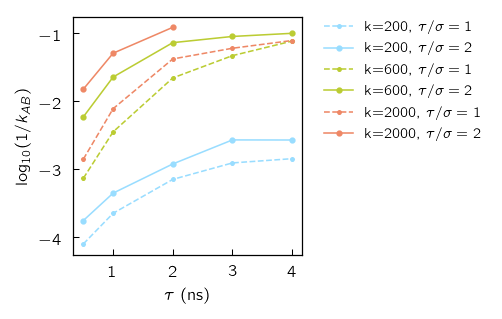

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), constrained_layout=True, sharex=True)

color_tmp = ["#77AADD", "#99DDFF", "#44BB99", "#BBCC33", "#AAAA00", "#EEDD88", "#EE8866", "#FFAABB"]
for i_k, k_id in enumerate(k_choice):
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(invk_AB[i_k, lag_choice, 0]), '*--', color=color_tmp[k_id], label=f"k={k_ls[k_id]}, $\\tau/\sigma=1$")
#for i_k, k_id in enumerate(k_choice):
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(invk_AB[i_k, lag_choice, 1]), 'o-', color=color_tmp[k_id], label=f"k={k_ls[k_id]}, $\\tau/\sigma=2$")
ax.set_xlabel("$\\tau$ (ns)")
ax.set_ylabel("$\log_{10}(1/k_{AB})$")
#ax.legend()
lgd=fig.legend(bbox_to_anchor=(-1.98, 1.02, 3.6, -0.01), bbox_transform=fig.transFigure, ncol=1,fontsize=7)#, ncols=4)
#plt.savefig(f"{workdir}/figure/step4_kAB_log_cm.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

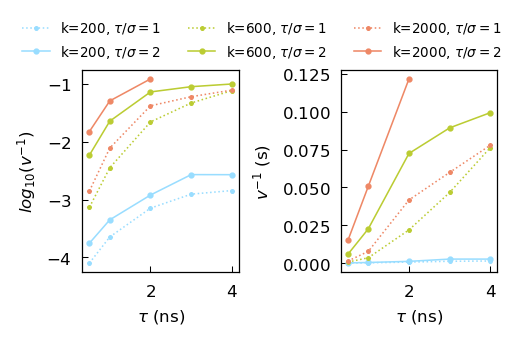

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(3.3, 1.8), constrained_layout=True, sharex=True)
ax = axs[0]
color_tmp = ["#77AADD", "#99DDFF", "#44BB99", "#BBCC33", "#AAAA00", "#EEDD88", "#EE8866", "#FFAABB"]
for i_k in k_choice:
    k = k_ls[i_k]
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(inv_rate_mem[i_k, lag_choice, 0]), '*:', color=color_tmp[i_k])#, label=f"k={k}, $\\tau/\sigma=1$"
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(inv_rate_mem[i_k, lag_choice, 1]), 'o-', color=color_tmp[i_k])#, label=f"k={k}, $\\tau/\sigma=2$"
ax.set_xlabel("$\\tau$ (ns)")
ax.set_ylabel("$log_{10}(v^{-1})$")
ax = axs[1]
for i_k in k_choice:
    k = k_ls[i_k]
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, inv_rate_mem[i_k, lag_choice, 0], '*:', label=f"k={k}, $\\tau/\sigma=1$", color=color_tmp[i_k])
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, inv_rate_mem[i_k, lag_choice, 1], 'o-', label=f"k={k}, $\\tau/\sigma=2$", color=color_tmp[i_k])
ax.set_xlabel("$\\tau$ (ns)")
ax.set_ylabel("$v^{-1}$ (s)")
lgd=fig.legend(bbox_to_anchor=(-2,1.1, 3.02, 0.1), bbox_transform=fig.transFigure, ncol=3,fontsize=6.5)#, ncols=4)
#plt.savefig(f"{workdir}/figure/step4_rate.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

Text(0, 0.5, '$log_{10}(v^{-1})$')

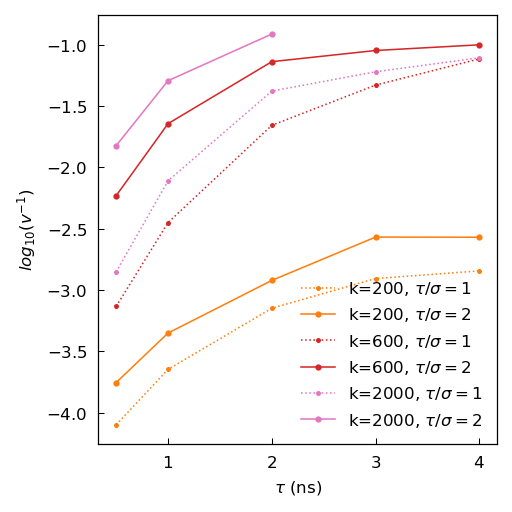

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3.3), constrained_layout=True, sharex=True)
for i_k in k_choice:
    k = k_ls[i_k]
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(inv_rate_mem[i_k, lag_choice, 0]), '*:', label=f"k={k}, $\\tau/\sigma=1$", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_k])
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(inv_rate_mem[i_k, lag_choice, 1]), 'o-', label=f"k={k}, $\\tau/\sigma=2$", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_k])
ax.legend()
ax.set_xlabel("$\\tau$ (ns)")
ax.set_ylabel("$log_{10}(v^{-1})$")
#plt.savefig(f"{workdir}/figure/step4_log_rate.pdf")

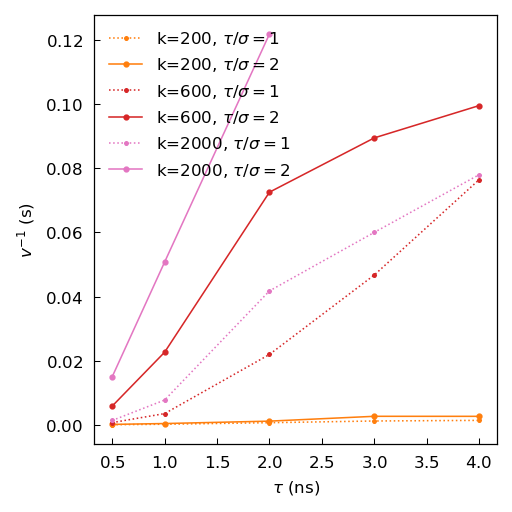

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3.3), constrained_layout=True, sharex=True)
for i_k in k_choice:
    k = k_ls[i_k]
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, inv_rate_mem[i_k, lag_choice, 0], '*:', label=f"k={k}, $\\tau/\sigma=1$", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_k])
    ax.plot(np.array(lag_ls)[lag_choice] * 0.005, inv_rate_mem[i_k, lag_choice, 1], 'o-', label=f"k={k}, $\\tau/\sigma=2$", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_k])
ax.legend()
ax.set_xlabel("$\\tau$ (ns)")
ax.set_ylabel("$v^{-1}$ (s)")
#plt.savefig(f"{workdir}/figure/step4_lin_rate.pdf")

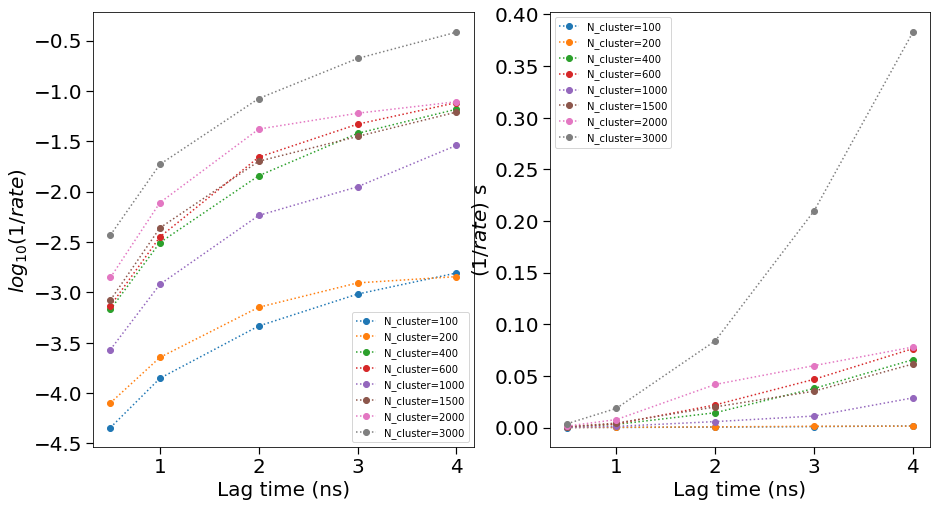

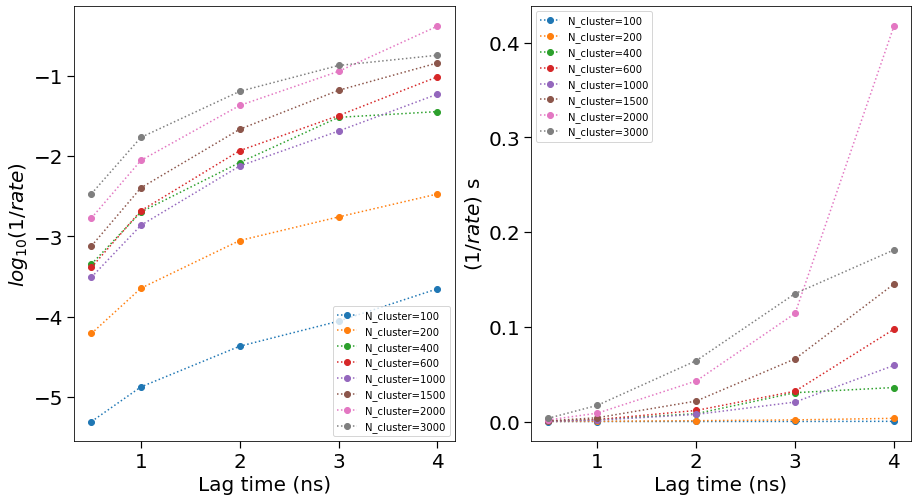

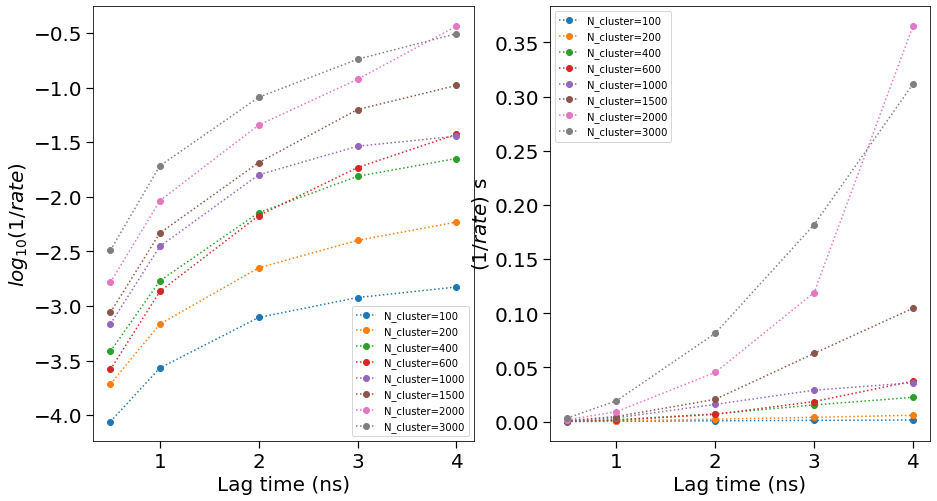

In [243]:
for i_rn in range(3):
    lag_choice = [0, 1, 2, 3, 4]
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    ax = axs[0]
    for i_l, (k, inv_r) in enumerate(zip(k_ls[:], inv_rate_arr[:, i_rn, :, 0])):
        ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(inv_r)[lag_choice], 'o:', label=f"N_cluster={k}", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_l])
        #ax.plot(np.array(lag_ls)[lag_choice] * 0.005, np.log10(inv_rate_mem[i_l, i_rn, lag_choice, 1]), 'x-', label=f"N_cluster={k}", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_l])
    ax.legend()

    ax.set_xlabel("Lag time (ns)")
    ax.set_ylabel("$log_{10}(1/rate)$")
    ax = axs[1]
    for i_l, (k, inv_r) in enumerate(zip(k_ls[:], inv_rate_arr[:,i_rn, :, 0])):
        ax.plot(np.array(lag_ls)[lag_choice] * 0.005, inv_r[lag_choice], 'o:', label=f"N_cluster={k}", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_l])
        #ax.plot(np.array(lag_ls)[lag_choice] * 0.005, inv_rate_mem[i_l, i_rn, lag_choice, 1], 'x-', label=f"N_cluster={k}", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_l])
    ax.legend()

    ax.set_xlabel("Lag time (ns)")
    ax.set_ylabel("$(1/rate)$ s")
    #ax.plot(np.log2(k_ls), loss_arr[:, :], 'o:', label="k=25")

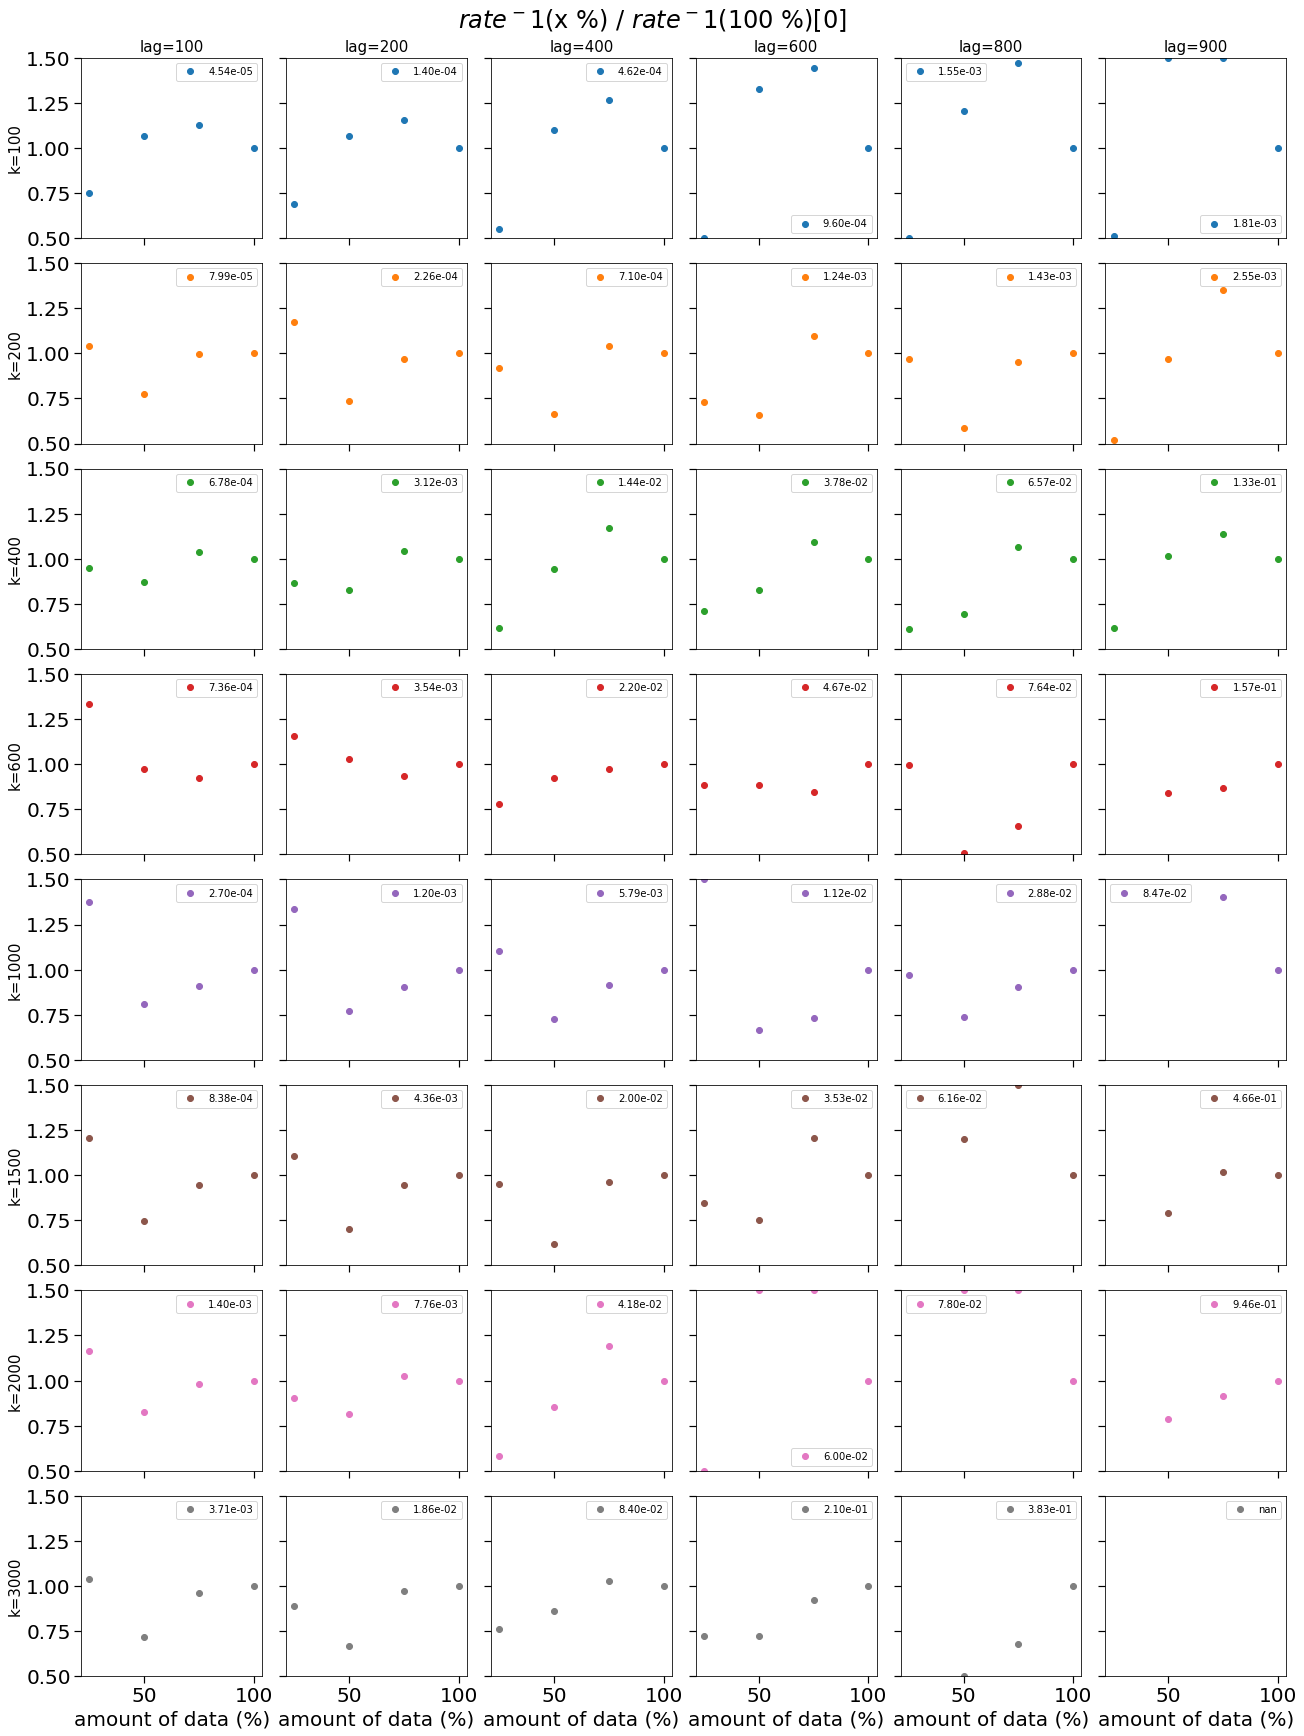

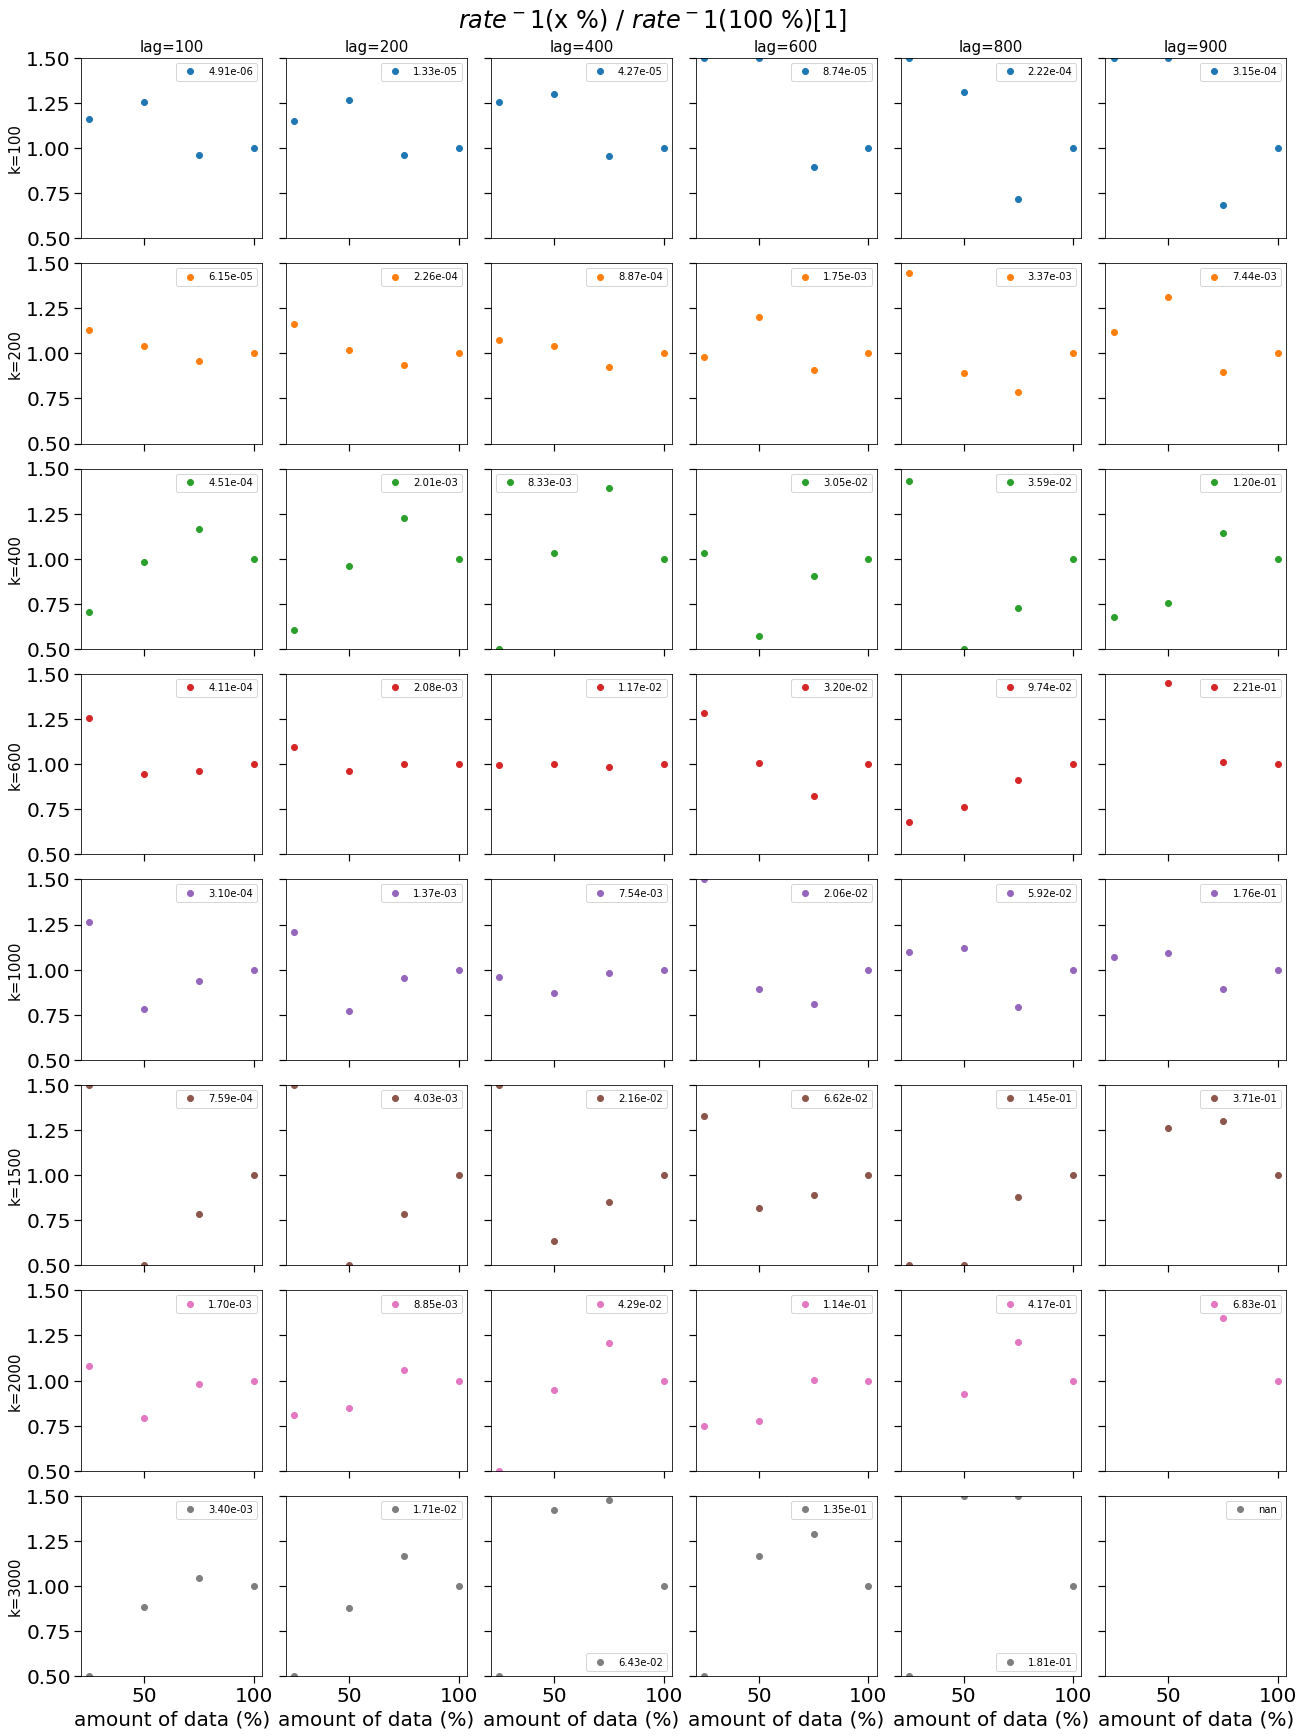

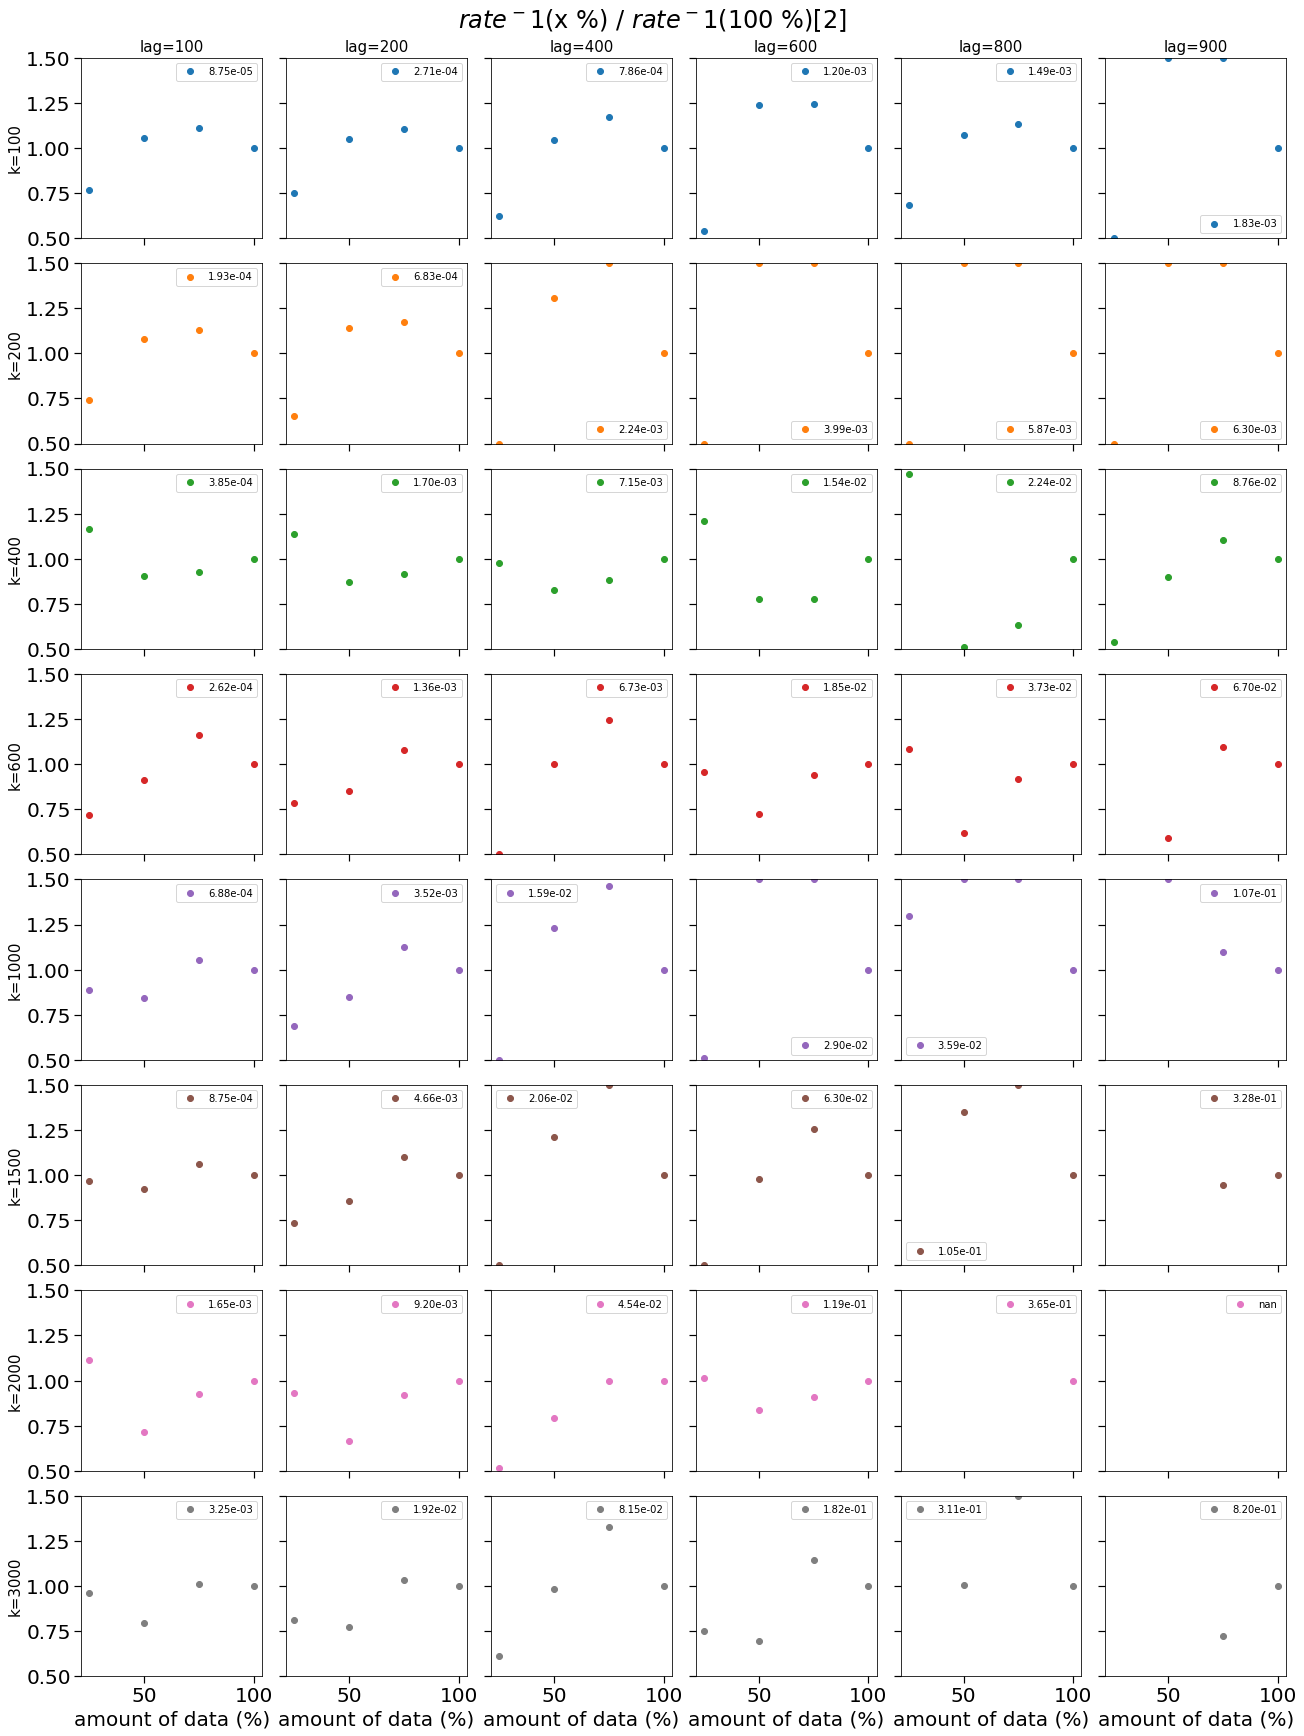

In [217]:
for i_rn in range(3):
    nrow, ncol = len(k_ls), len(lag_ls)
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*3), sharex=True, sharey=True, constrained_layout=True)
    for i_k, k in enumerate(k_ls):
        axs[i_k, 0].set_ylabel(f"k={k}", fontsize=15)
        for i_lag, lag in enumerate(lag_ls):
            if i_k == 0:
                axs[0, i_lag].set_title(f"lag={lag}", fontsize=15)
            arr_tmp = inv_rate_arr[i_k, i_rn, i_lag, ::-1]/inv_rate_arr[i_k, i_rn, i_lag, 0]
            arr_tmp = np.copy(np.clip(arr_tmp, a_min=0.5, a_max=1.5))
            axs[i_k, i_lag].plot([25, 50, 75, 100], arr_tmp, 'o',\
                                    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i_k],
                                    label=f"{inv_rate_arr[i_k, i_rn, i_lag, 0]:.2e}"
                                    )
            axs[i_k,i_lag].legend()
            axs[i_k, i_lag].set_ylim(0.5, 1.5)
            if i_k == len(k_ls)-1:
                axs[i_k, i_lag].set_xlabel("amount of data (%)")
    fig.suptitle(f"$rate^{-1}$(x %) / $rate^{-1}$(100 %)[{i_rn}]", fontsize=24)
